In [1]:
!pip install wget
import wget
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=79736f0ba4f4152360c751769b08a3203404e0f57f968b8dc4b13981addeea23
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


Nun betrachten wir einen Datensatz mit korrekt/inkorrekt getragenen Gesichtsmasken.

Es gibt diese Möglichkeiten zur Nutzung der Maske:
- Korrekte Nutzung
- Kinn
- Mund/Nase
- Mund/Kinn

In [2]:
classes = ['correct', 'chin', 'mouth_nose', 'mouth_chin']

Zuerst laden wir den präparierten Datensatz herunter und entpacken diesen.

In [3]:
if not os.path.isdir("data/MaskFace-Net"):
    wget.download("https://oshi.at/NVKYum", bar=wget.bar_adaptive)

    import zipfile
    with zipfile.ZipFile("jOLG.zip", "r") as zip_ref:
        zip_ref.extractall("")

In [4]:
train_path = 'data/MaskFace-Net/train'
valid_path = 'data/MaskFace-Net/valid'
test_path = 'data/MaskFace-Net/test'

Nun erzeugen wir aus den Ordnern die zugehörigen Batches.
`tf.keras.applications.vgg16.preprocess_input` passt hierbei den Input
noch für das neuronale Netz an.
`flow_from_directory` erzeugt augmentierte Bilder.
In unserem Beispiel werden diese einfach auf die Größe `256x256` skaliert.

In [5]:
image_size = 256
batch_size = 10

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size, shuffle=False)

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [6]:
assert train_batches.n == 4*300
assert valid_batches.n == 4*100
assert test_batches.n == 4*50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 4

In [7]:
import matplotlib.pyplot as plt

def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Sehen wir uns das erste Trainingsbatch kurz an.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

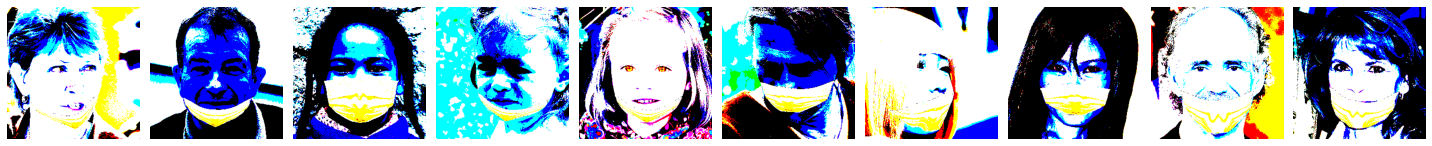

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [8]:
imgs, labels = next(train_batches)

plot_images(imgs)
print(labels)

Nun kommen wir endlich zu unserem neuronalen Netz.
Wir verwenden ein Convolutional Neural Network, das durch `tf.keras.models.Sequential`
realisiert und verwendet zwei `tf.keras.layers.Conv2D`-Ebenen, zwei `tf.keras.layers.MaxPool2D`-Ebenen
und zum Schluss noch ein Fully-connected Layer, welches wir durch `tf.keras.layers.Flatten`
und `tf.keras.layers.Dense` bekommen.

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)),
    MaxPool2D(pool_size=(4,4), strides=4),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 131076    
Total params: 141,220
Trainable params: 141,220
Non-trainable params: 0
__________________________________________________

Für unsere Loss-Funktion verwenden wir Categorical Crossentropy
und für den Optimierer verwenden wir `tf.keras.optimizers.Adam`,
da dieser bessere Ergebnisse als Stochastic Gradient Descent liefert.

In [10]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Mit `fit()` trainieren wir das neuronale Netz.

In [11]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=2, verbose=2)

Epoch 1/2
120/120 - 78s - loss: 8.6440 - accuracy: 0.8150 - val_loss: 0.1024 - val_accuracy: 0.9625
Epoch 2/2
120/120 - 77s - loss: 0.0778 - accuracy: 0.9817 - val_loss: 0.1448 - val_accuracy: 0.9600


Betrachten wir nun das Test-Set.
Da das Test-Set nicht gemischt wurde,
sind die ersten Bilder alles korrekt getragene Masken.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

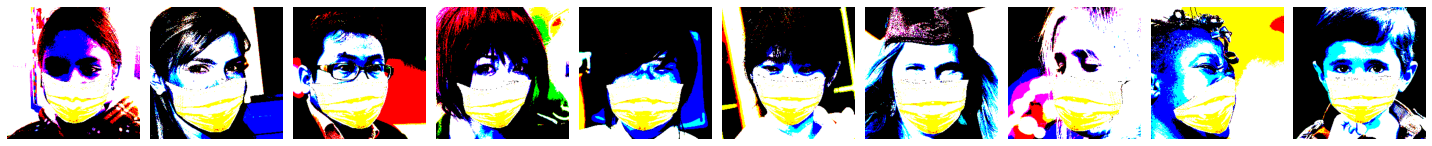

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [12]:
test_imgs, test_labels = next(test_batches)
plot_images(test_imgs)
print(test_labels)

Nun sagen wir das Test-Set mithilfe unseres trainierten Netzes mit `predict()` vor.

In [13]:
predictions = model.predict(x=test_batches, verbose=0)

In [14]:
import numpy as np
preds = np.argmax(predictions, axis=1)
print("Predictions:\n", preds)
print("Actual:\n", test_batches.classes)
print("Accuracy:", sum(preds == test_batches.classes)/preds.shape[0])

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Actual:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Accuracy: 0.95


In [15]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, classes, title='Konfusionsmatrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() * 2. / 3
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Tatsächlich')
    plt.xlabel('Vorhersage')

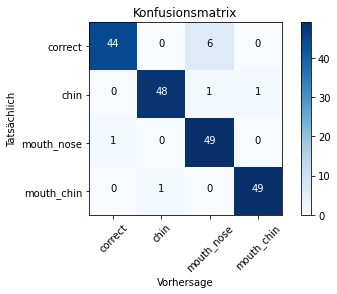

In [16]:
plot_cm(test_batches.classes, preds, classes)